In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# combine all data table together into one dataframe
for i in range(1,71):
    if i == 1:
        patient = "01"
        filename = 'Diabetes-Data/data-'+ patient
        rawdata = pd.read_table(filename, names = ["date", "time","code", "value" ])
        rawdata['patient'] = patient
    else:
        if i < 10 and i != 1:
            patient = "0" + str(i)
        else:
            patient = str(i)
        filename = 'Diabetes-Data/data-' + patient
        temp = pd.read_table(filename, names = ["date", "time","code", "value" ])
        temp['patient'] = patient

        rawdata = pd.concat([rawdata, temp])

data = rawdata.copy()
data['patient'] = pd.to_numeric(data['patient'], errors='coerce', downcast="integer")

data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29330 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29297 non-null  object
 1   time     29330 non-null  object
 2   code     29330 non-null  int64 
 3   value    29297 non-null  object
 4   patient  29330 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.1+ MB


In [17]:
# remove rows with missing values
data = data.dropna()

#drop non numeric values of "value" and change value from object to float, then drop N/A values
data['value'] = pd.to_numeric(data['value'], errors='coerce')
data = data.dropna()

data

,date,time,code,value,patient
0,04-21-1991,9:09,58,100.0,1
1,04-21-1991,9:09,33,9.0,1
2,04-21-1991,9:09,34,13.0,1
3,04-21-1991,17:08,62,119.0,1
4,04-21-1991,17:08,33,7.0,1
...,...,...,...,...,...
336,05-09-1989,08:00,33,1.0,70
337,05-09-1989,08:00,34,7.0,70
338,05-10-1989,08:00,34,7.0,70
339,05-11-1989,08:00,34,7.0,70


In [18]:
#convert time column into mins
data['time'] = data['time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29256 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     29256 non-null  object 
 1   time     29256 non-null  int64  
 2   code     29256 non-null  int64  
 3   value    29256 non-null  float64
 4   patient  29256 non-null  int8   
dtypes: float64(1), int64(2), int8(1), object(1)
memory usage: 1.1+ MB


In [19]:
#drop time values that are over 1440 (amount of minutes in a day)
data = data[data.time < 1440]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29251 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     29251 non-null  object 
 1   time     29251 non-null  int64  
 2   code     29251 non-null  int64  
 3   value    29251 non-null  float64
 4   patient  29251 non-null  int8   
dtypes: float64(1), int64(2), int8(1), object(1)
memory usage: 1.1+ MB


In [20]:
# turn exercise codes into new exercise column
conditions = [(data['code'] == 69), (data['code'] == 70), (data['code'] == 71)]
choices = [2, 3, 1] #1 = less than normal, 2 = typical, 3 = more than normal
data['exercise'] = np.select(conditions, choices, default=0)
    
data

/tmp/ipykernel_8896/737210334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['exercise'] = np.select(conditions, choices, default=0)


,date,time,code,value,patient,exercise
0,04-21-1991,549,58,100.0,1,0
1,04-21-1991,549,33,9.0,1,0
2,04-21-1991,549,34,13.0,1,0
3,04-21-1991,1028,62,119.0,1,0
4,04-21-1991,1028,33,7.0,1,0
...,...,...,...,...,...,...
336,05-09-1989,480,33,1.0,70,0
337,05-09-1989,480,34,7.0,70,0
338,05-10-1989,480,34,7.0,70,0
339,05-11-1989,480,34,7.0,70,0


In [21]:
data['daily_exercise'] = data.groupby(['date','patient'])["exercise"].transform('max')
data

/tmp/ipykernel_8896/9832237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['daily_exercise'] = data.groupby(['date','patient'])["exercise"].transform('max')


,date,time,code,value,patient,exercise,daily_exercise
0,04-21-1991,549,58,100.0,1,0,0
1,04-21-1991,549,33,9.0,1,0,0
2,04-21-1991,549,34,13.0,1,0,0
3,04-21-1991,1028,62,119.0,1,0,0
4,04-21-1991,1028,33,7.0,1,0,0
...,...,...,...,...,...,...,...
336,05-09-1989,480,33,1.0,70,0,0
337,05-09-1989,480,34,7.0,70,0,0
338,05-10-1989,480,34,7.0,70,0,0
339,05-11-1989,480,34,7.0,70,0,0


In [8]:
data.iloc[4500:4530, :]

,date,time,code,value,patient,exercise,daily_exercise
46,03-18-1991,1088,62,92.0,14,0,2
47,03-18-1991,1089,33,2.0,14,0,2
48,03-18-1991,1089,34,3.0,14,0,2
49,03-18-1991,1090,66,0.0,14,0,2
50,03-18-1991,1090,69,0.0,14,2,2
51,03-18-1991,1090,72,0.0,14,0,2
52,03-18-1991,1261,64,272.0,14,0,2
53,03-18-1991,1263,33,2.0,14,0,2
54,03-18-1991,1263,34,6.0,14,0,2
55,03-18-1991,1263,67,0.0,14,0,2


In [22]:
#drop columns date, patient, code and exercise
data = data.drop(columns=['date', 'code', 'patient', 'exercise'])
data

,time,value,daily_exercise
0,549,100.0,0
1,549,9.0,0
2,549,13.0,0
3,1028,119.0,0
4,1028,7.0,0
...,...,...,...
336,480,1.0,0
337,480,7.0,0
338,480,7.0,0
339,480,7.0,0


<AxesSubplot:>

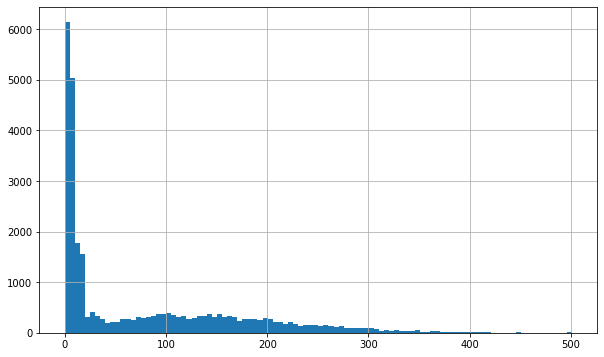

In [10]:
plt.figure(figsize=(10, 6))
data['value'].hist(bins=100)

In [23]:
# drop all rows that have blood glucose = 0
data = data[data.value != 0]
data

,time,value,daily_exercise
0,549,100.0,0
1,549,9.0,0
2,549,13.0,0
3,1028,119.0,0
4,1028,7.0,0
...,...,...,...
336,480,1.0,0
337,480,7.0,0
338,480,7.0,0
339,480,7.0,0


<AxesSubplot:>

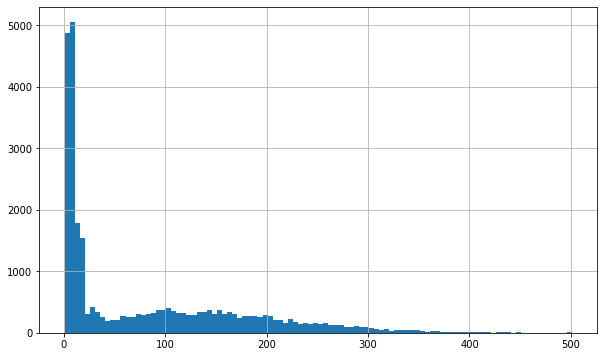

In [12]:
plt.figure(figsize=(10, 6))
data['value'].hist(bins=100)

In [24]:
X = data[['time', 'daily_exercise']]
y = data['value']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#from sklearn.ensemble import RandomForestRegressor
#regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
#regressor.fit(X_train, y_train)
# rdm forest regressor CLASSIFIES!!!! blood sugar is continuous!

In [32]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = regr.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.014187834339364325

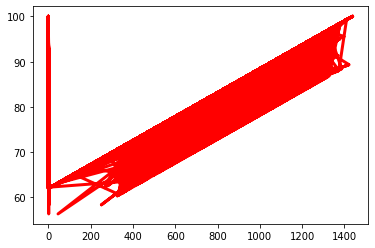

In [34]:
plt.plot(X_test, regr.predict(X_test), color = 'red', linewidth = 3)
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print ('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:


ValueError: continuous is not supported

In [ ]:
# interested only in codes:
    #69 = Typical exercise activity
    #70 = More-than-usual exercise activity
    #71 = Less-than-usual exercise activity 
#training_data = data.loc[(data["exercise"] == 1) | (data["exercise"] == 2) | (data["exercise"] == 3)]
#training_data.head(30)
